Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

Structure inspired from https://github.com/Physics-aware-AI/Symplectic-ODENet/blob/master/experiment-single-force/data.py

# Setting up directories

In [3]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    PATH = './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install torchdiffeq
    # !pip install torchdiffeq
    #   # Clone the entire repo to access the files.
    #   !git clone -l -s https://github.com/....... repo
    # Mount your google drive 

import sys; sys.path.insert(0, '..') 
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

# Imports

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from src.furuta.data import *
from src.furuta.dynamics import *
from src.furuta.models import *
from src.furuta.train import *
from src.furuta.plots import *
from src.furuta.trajectories import *
from src.furuta.utils import *

# Generating the data

## Without dataloader

In [6]:
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = 'fake')

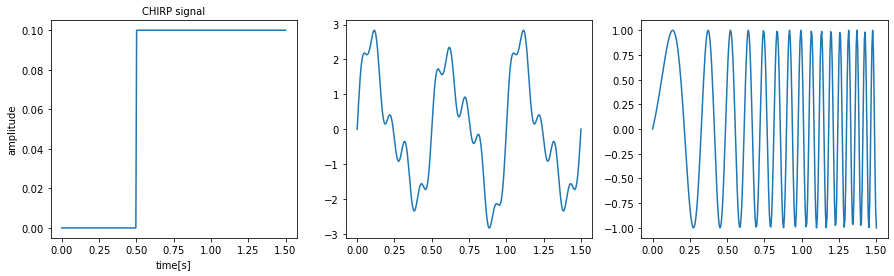

In [11]:
t=torch.linspace(0,1.5,300)

signal1 = step_fun(t, t1=0.5)
signal2 = multi_sine(t)
signal3 = chirp_fun(t,T=1.5,f0=1,f1=20)

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(t, signal1)
ax[0].set_title('Step signal', fontsize=10)
ax[0].set_xlabel('time[s]')
ax[0].set_ylabel('amplitude')
ax[1].plot(t, signal2)
ax[0].set_title('multisine signal', fontsize=10)
ax[0].set_xlabel('time[s]')
ax[0].set_ylabel('amplitude')
ax[2].plot(t, signal3)
ax[0].set_title('CHIRP signal', fontsize=10)
ax[0].set_xlabel('time[s]')
ax[0].set_ylabel('amplitude')
plt.show()

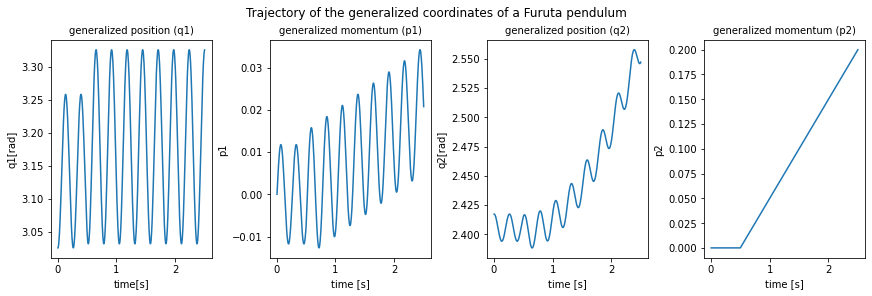

In [20]:
q1, p1, q2, p2, t_eval = get_trajectory_furuta(utype='step', 
                                                gtype='simple', 
                                                init_method = 'random_closetopi', 
                                                u_func=u_func, g_func=g_func, 
                                                time_steps=500, y0=None, 
                                                noise_std=0.0, Ts=Ts,
                                                C_q1=C_q1, C_q2=C_q2, 
                                                g=g , Jr=Jr, Lr=Lr, 
                                                Mp=Mp , Lp=Lp) #, C_q1=0.000009, C_q2=0.00004)

plot_traj_furuta(t_eval, q1, p1, q2, p2, title = 'Trajectory of the generalized coordinates of a Furuta pendulum', 
                      coord_type='hamiltonian')

## With dataloader

In [51]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(utype='CHIRP', 
                    gtype='simple', init_method = 'random_closetopi',time_steps=300,
                    num_trajectories=5, u_func=u_func, g_func=g_func, 
                    y0=None, Ts = Ts, noise_std=0.0, C_q1 = C_q1,

                    C_q2 = C_q2,g = g , Jr = Jr, Lr = Lr, Mp = Mp , Lp = Lp)
u = u_func(t_eval,'CHIRP')

train_loader, test_loader = data_loader_furuta(u, q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=3,
                       shuffle = True, proportion = 0.0, coord_type='newtonian')

torch.Size([3, 4, 300])


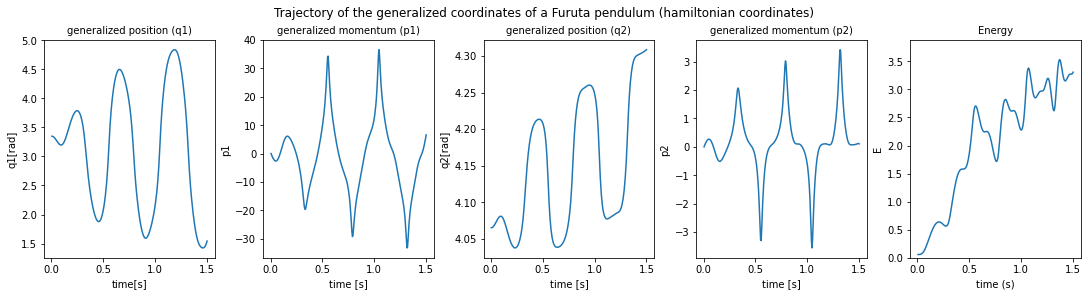

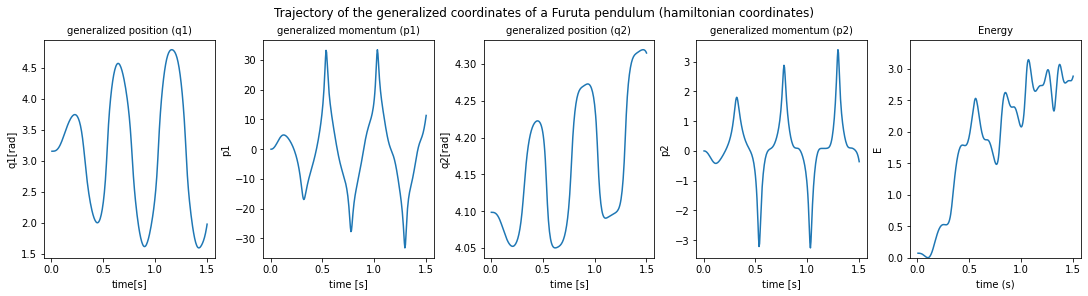

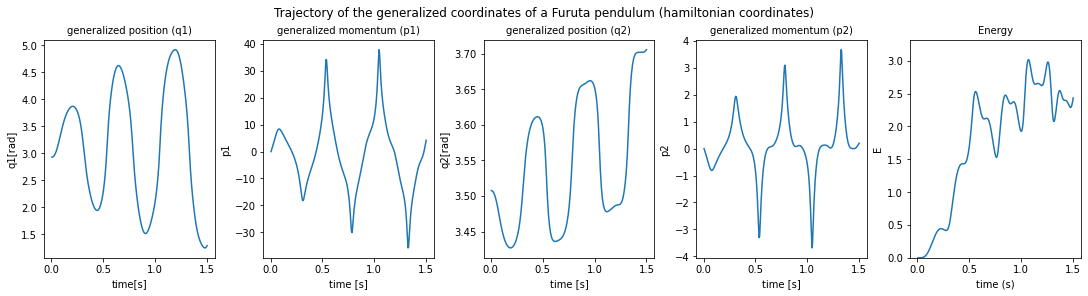

In [52]:
# sanity checks
u_tt, x_tt, t_eval_tt = next(iter(train_loader))
print(x_tt.shape)
for n in range(3):
    q1_t = x_tt[n,0,:]
    p1_t = x_tt[n,1,:]
    q2_t = x_tt[n,2,:]
    p2_t = x_tt[n,3,:]

    plot_traj_furuta(t_eval_tt[n], q1_t, p1_t, q2_t, p2_t,energy[n,:],
                    title = 'Trajectory of the generalized coordinates of a Furuta pendulum (hamiltonian coordinates)', coord_type='hamiltonian')